# **Chapter 03-a. Transfer Learning**

### **Outline**
* 分類模型的最後一層(輸出層)通常是 Dense layer, 而在它之前的倒數第二層被稱作 `embedding (嵌入)`, `input 影像的所有資訊都由這一層來表達`
* 這一張的重點為 如何建立 embedding, 及 如何使用 embedding 於 transfer learning 和 fine-tuning 上

---
## **Transfer Learning**
* 假設我們有一個自己建立的 model, 但它的成效因為訓練資料不足所以不佳; 而有另一個 pre-trained model 已經在更大的資料集上訓練過, 它的任務目標與我們的需求相似但不一致
* 此時我們可以利用 pre-trained model 的 embedding, `丟棄原先的最後一層 (prediction head) 再加上我們自己新的 prediction head` 即可！
* 而 `embedding 層通常不丟棄，而是保留、甚至凍結（不更新參數）`, 因為這些層學會了提取「邊緣、形狀、紋理」這類通用的特徵, 即使任務不同，這些特徵在圖像處理上仍然非常有用
* 若新任務資料量很少 → 只替換 prediction head，其他層凍結，不訓練; 若新任務和原任務差異很大（例如醫療圖像 vs. 貓狗圖片）→ 可以考慮換掉更多層，甚至微調整個模型。
* ⭐️⭐️⭐️ **只有當你的資料集中 `每個 label 都有超過 5000 張影像時, 才應該考慮從頭訓練 model`！**

##### Setup

In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(model, filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);
    ax[flower].axis('off')

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
print("These are the available classes:", CLASS_NAMES)

# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### **Transfer Learning with MobileNet**
* MobileNet 是利用 ImageNet資料集(數百萬張圖片) 訓練出來的 model, 能夠分辨1000種類別
* 這裡利用 MobileNet 當作我們訓練模型的第一層, 再接上 一層embedding + 一層prediction head

In [5]:
import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    train_dataset = (tf.data.TextLineDataset(
        "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv").
        map(decode_csv)).batch(batch_size)

    eval_dataset = (tf.data.TextLineDataset(
        "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv").
        map(decode_csv)).batch(32) # this doesn't matter

    # 第一層原本是 Flatten layer, 現在改成 pre-trained 過的 MobileNet
    # trainable = False, 代表凍結他(不要讓他訓練好的參數被修改)
    layers = [
        hub.KerasLayer(
            "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
            input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
            trainable=False,
            name='mobilenet_embedding'),
        tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation='relu',
                            name='dense_hidden'),
        tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
    ]

    model = tf.keras.Sequential(layers, name='flower_classification')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    print(model.summary())
    
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=5)
    training_plot(['loss', 'accuracy'], history)
    return model

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (Keras  (None, 1280)              2257984   
 Layer)                                                          
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 2278565 (8.69 MB)
Trainable params: 20581 (80.39 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
None
Epoch 1/5
104/104 [==============================] - 282s 3s/step - loss: 0.7503 - accuracy: 0.7388 - val_loss: 0.4397 - val_accuracy: 0.8378
Epoch 2/5
104/104 [==============================] - 28

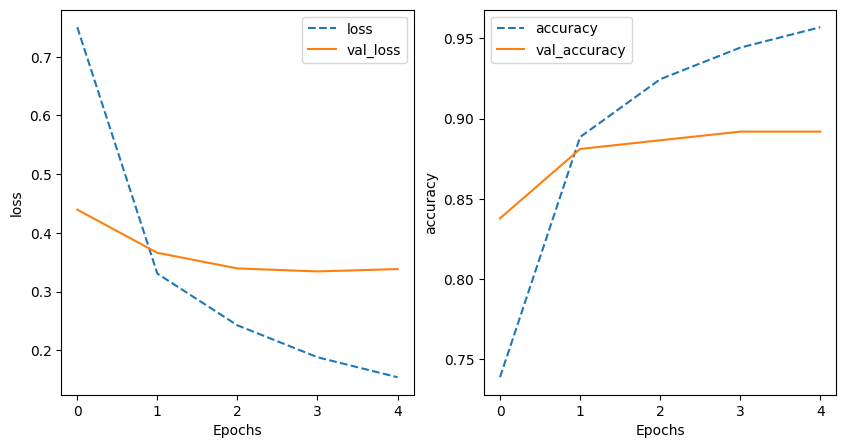

In [6]:
model = train_and_evaluate()

由上圖可見, evaluation set 上的準確率可以達到**近90%**!

1/1 [==============================] - 0s 22ms/step


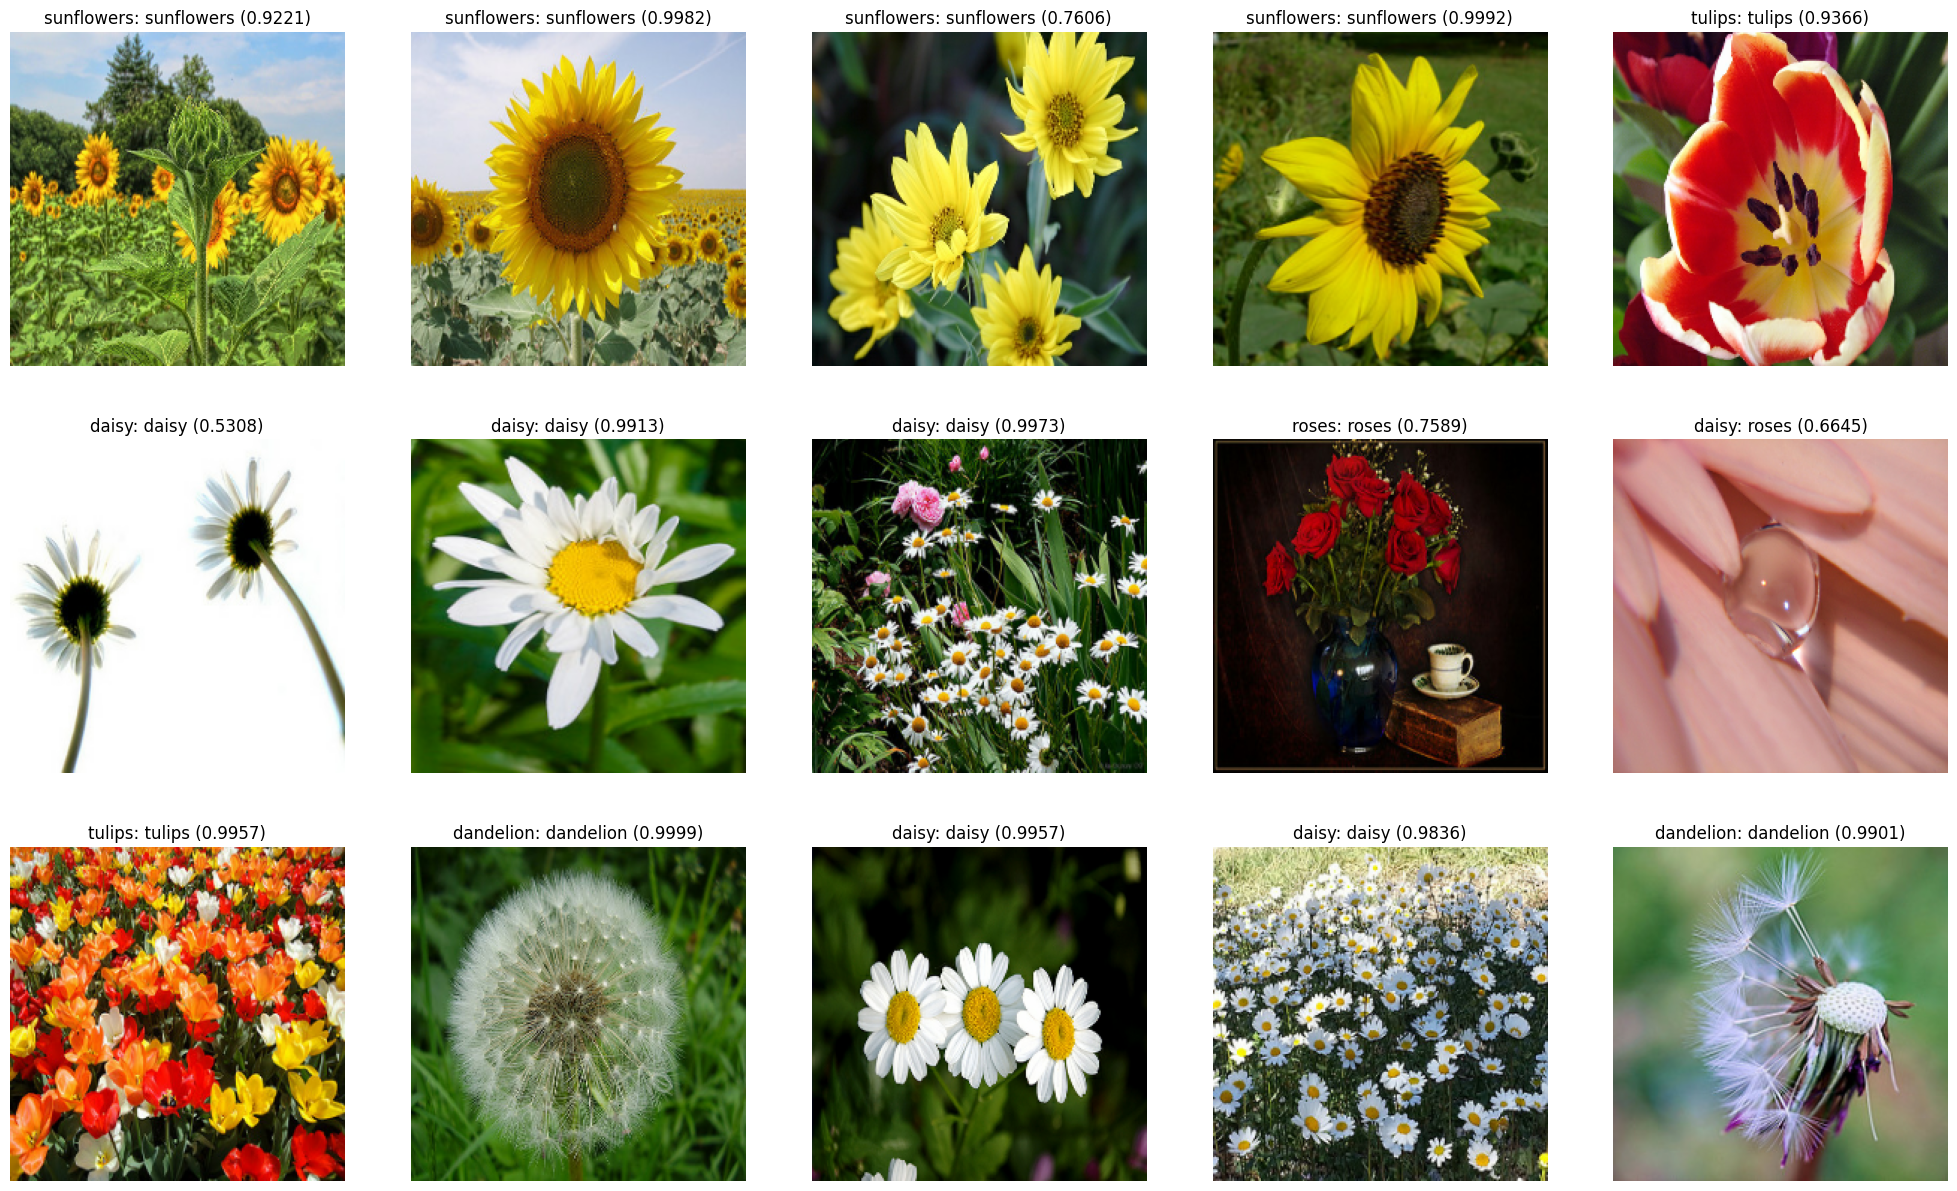

In [7]:
plot_predictions(model, "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv")